First we inport our libraries:

In [31]:
import scipy
from scipy.integrate import quad
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

The determinant, $$\frac{d\phi}{dr}=\pm\frac{b}{\sqrt{r^4-b^2(r^2-2Mr)}}$$, we can call radial potential, the function for which is

In [32]:
def radial_potential(r, b):
  return r**4 - b**2*r**2 + 2*b**2*r

Now we make a function that intakes an r and a b value and returns $\frac{d\phi}{dr}$, using the radial potential function from before in the sqaure root.

In [33]:
def d_phi_dr(r, b):
  return b / np.sqrt(radial_potential(r, b))

We know that the integral $$\phi=\int\frac{d\phi}{dr}dr$$ how we get $\phi$. In code bellow is exactly that in code, quad is an integral of (function, lower bound, upper bound, input value). So we are integrating $\frac{d\phi}{dr}$ at b from rs to infinity.

In [34]:
def phi(rs, b):
  return quad(d_phi_dr, rs, np.inf, args=(b))

Now we can draw our first trajectory! Here we define a few variables, b is the impact parameter
<img src="https://upload.wikimedia.org/wikipedia/commons/0/0c/Impctprmtr.png" alt="drawing" width="200" height="200"/>
, rs is the minimum radius of circular orbits, rmax is the maximum radius we are graphing and steps is a resolution of the graph.

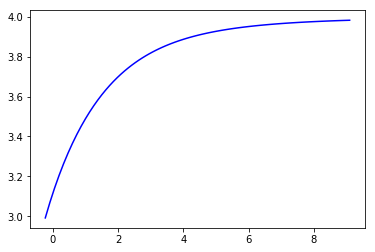

In [35]:
b = 4
steps = 100
rs = 3
rmax = 10
# creating a list of coordinate values
coords = [[step*(rmax-rs)/steps+rs, phi(step*(rmax-rs)/steps+rs, b)[0]] for step in range(0,steps)]
x_vals = list(map(lambda x: x[0]*np.cos(x[1]),coords))
y_vals = list(map(lambda x: x[0]*np.sin(x[1]),coords))
plt.plot(x_vals, y_vals, 'b')
#will show one trajectory at b=4 in spacetime
plt.show()

This function will have a turning point, a point where the first derivative is zero. This leads us to choosing a different parameterization to 

In [37]:
#choosing an alternate parametrization to get around the turning point of the function as he says.
def d_phi_dx(x, b, rt):
  return -2*b*np.abs(x) / \
    (
        (x**2+rt) * np.sqrt(-((b**2*(-2+x**2+rt)) / (x**2+rt)) + (x**2+rt)**2)
    )

minrs...

In [36]:
def minrs(b):
  temp = np.cbrt(b**2)*((-1 + np.sqrt(1+0j-b**2/27))**(1/3)+(-1 - np.sqrt(1+0j-b**2/27))**(1/3))
  return np.real(temp).real if np.imag(temp) < 1e-10 else 0

In [38]:
def phi(xi, b):
  rt = minrs(b)
  if xi.imag != 0:
    return np.inf
  if rt == 0 and xi <0:
    return quad(d_phi_dx, np.inf, 0, args=(b,rt))
  return quad(d_phi_dx, np.inf, xi, args=(b,rt))

In [39]:
#looping through many b values and making a trajectory
def generate_trajectory(ximin, ximax, b, steps):
  rt = minrs(b)
  coords = np.ndarray([steps,2])
  for step in range(steps):
    xi = step*(ximax - ximin)/steps + ximin
    rs = 0 if rt == 0 and xi < 0 else (xi**2 + rt)
    coords[step][0] = rs
    coords[step][1] =  phi(xi, b)[0]
  x_vals = list(map(lambda x: x[0]*np.cos(x[1]),coords))
  y_vals = list(map(lambda x: x[0]*np.sin(x[1]),coords))
  return x_vals, y_vals

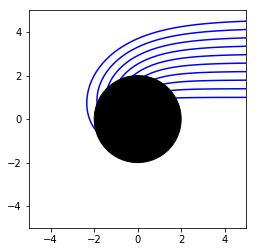

In [40]:
binit = 1
bfinal = 5
ncurves = 10

for i in range(ncurves):
  plt.plot(*generate_trajectory(1, 3, i*(bfinal-binit)/ncurves + binit, 100), 'b')

#just making the graph look nice with a black circle and a good scale
plt.xlim([-5, 5])
plt.ylim([-5, 5])
ax = plt.gca()
ax.set_aspect(1)
ax.add_patch(plt.Circle((0, 0), 2, color='k', zorder=10))
#will show "ncurves" many trajectories along with the black hole in the center.
plt.show()

In [41]:
#next to make the accretion disk
def psi(phi, theta):
  return np.arccos(np.sin(theta)*np.sin(phi))

In [42]:
def varphi(phi, theta):
  return np.arccos(np.cos(phi)/(np.sqrt(np.cos(phi)**2 + np.cos(theta)**2*np.sin(phi)**2)))

Next, looking ahead, we'll have a lot of complex and imaginary numbers. Using numpy with these numbers is supported, but they give warnings since most people don't want negatives in their sqaure roots. I will suppress those warnings.

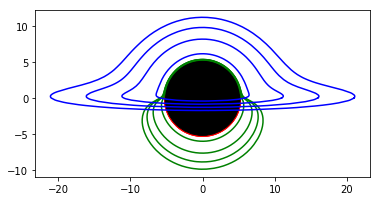

In [43]:
import warnings
warnings.filterwarnings('ignore')

steps = 2000
theta = 85*np.pi/180
rmin = 5
rmax = 25
rsteps = 5

#n is the amount of intersections the trajectory has with the accretion disk
#n = 0
for rs in range(rmin, rmax, rsteps):
  bmax = np.sqrt(rs**3/ (rs-2))+1
  phivals = np.linspace(0.0001*np.pi,2*np.pi*0.9999,num=steps)
  varphivals = np.array([np.pi if phi >= np.pi else 0 for phi in phivals])+np.arccos(np.sign(np.pi-phivals)*np.cos(phivals)/np.sqrt(np.cos(phivals)**2 +np.sin(phivals)**2*np.cos(theta)**2))
  psivals1 = np.array([psi(phi, theta) for phi in phivals])
  psivals2 = np.array([[phi(np.sqrt(rs - minrs(b)), b)[0],b] for b in np.linspace(0,bmax,num=steps)])
  psivals3 = np.array([[phi(-np.sqrt(rs - minrs(b)), b)[0],b] for b in np.linspace(3,bmax,num=steps)])
  bvals = np.array([min([min(psivals2, key=lambda x:abs(x[0]-psi)), min(psivals3, key=lambda x:abs(x[0]-psi))], key=lambda x:abs(x[0]-psi ))[1] for psi in psivals1])
  alphavals = (bvals) * np.cos(varphivals)
  betavals = -(bvals) * np.sin(varphivals)
  plt.plot(alphavals, betavals, 'b', zorder=9)


#n=1    
for rs in range(rmin, rmax, rsteps):
  bmax = np.sqrt(rs**3/ (rs-2))+1
  phivals = np.linspace(0.001*np.pi,2*np.pi*0.999,num=steps)
  varphivals = np.array([np.pi if phi >= np.pi else 0 for phi in phivals])+np.arccos(np.sign(np.pi-phivals)*np.cos(phivals)/np.sqrt(np.cos(phivals)**2 +np.sin(phivals)**2*np.cos(theta)**2))
  psivals1 = np.pi + np.array([psi(phi, theta) for phi in phivals]) # n=1 is pi degrees away from n=0
  psivals2 = np.array([[phi(-np.sqrt(rs - minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  psivals3 = np.array([[phi(-np.sqrt(rs - minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  bvals = np.array([min([min(psivals2, key=lambda x:abs(x[0]-psi)), min(psivals3, key=lambda x:abs(x[0]-psi))], key=lambda x:abs(x[0]-psi ))[1] for psi in psivals1])
  alphavals = (bvals) * np.cos(varphivals)
  betavals = -(bvals) * np.sin(varphivals)
  plt.plot(alphavals, betavals, 'g', zorder=8)


#n=2    
for rs in range(rmin, rmax, rsteps):
  bmax = np.sqrt(rs**3/ (rs-2))+1
  phivals = np.linspace(0.001*np.pi,2*np.pi*0.999,num=steps)
  varphivals = np.array([np.pi if phi >= np.pi else 0 for phi in phivals])+np.arccos(np.sign(np.pi-phivals)*np.cos(phivals)/np.sqrt(np.cos(phivals)**2 +np.sin(phivals)**2*np.cos(theta)**2))
  psivals1 = 2*np.pi + np.array([psi(phi, theta) for phi in phivals]) # n=2 is 2pi degrees away from n=0
  psivals2 = np.array([[phi(-np.sqrt(rs - minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  psivals3 = np.array([[phi(-np.sqrt(rs - minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  bvals = np.array([min([min(psivals2, key=lambda x:abs(x[0]-psi)), min(psivals3, key=lambda x:abs(x[0]-psi))], key=lambda x:abs(x[0]-psi ))[1] for psi in psivals1])
  alphavals = (bvals) * np.cos(varphivals)
  betavals = -(bvals) * np.sin(varphivals)
  plt.plot(alphavals, betavals, 'r', zorder=7)


ax = plt.gca()   
ax.add_patch(plt.Circle((0, 0), np.sqrt(27), color='k', zorder=8))


ax.set_aspect(1)

#will show the completed project!
plt.show()